In [1807]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Distribution

import numpy as np
import pandas as pd

In [1808]:
from typing import Any ,List

General case:
- Choose a prior for $Z$: $p(Z)$.
- Choose an observation model: $p_\theta(X|Z)$
- Choose a variational posterior: $q_{\gamma}(\mathbf{z} | \mathbf{x})$

- Choose a missing model: $p_{\phi}(\mathbf{S} | \mathbf{X^o, X^m})$


The ELBO in the MNAR case is

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$

### Classic case
The model we are building has a Gaussian prior and a Gaussian observation model (also the decoder ($z \rightarrow x$) ),

$$ p(\mathbf{z}) = \mathcal{N}(\mathbf{z} | \mathbf{0}, \mathbf{I})$$

$$ p_\theta(\mathbf{x} | \mathbf{z}) = \mathcal{N}(\mathbf{x} | \mathbf{\mu}_{\theta}(\mathbf{z}), \sigma^2\mathbf{I})$$

$$ p_\theta(\mathbf{x}) = \int p_\theta(\mathbf{x} | \mathbf{z})p(\mathbf{z}) d\mathbf{z}$$

where $\mathbf{\mu}_{\theta}(\mathbf{z}): \mathbb{R}^d \rightarrow \mathbb{R}^p $ in general is a deep neural net, but in this case is a linear mapping, $\mathbf{\mu} = \mathbf{Wz + b}$.

The variational posterior (also the encoder ($x \rightarrow z$) ) is also Gaussian

$$q_{\gamma}(\mathbf{z} | \mathbf{x}) = \mathcal{N}(\mathbf{z} | \mu_{\gamma}(\mathbf{x}), \sigma_{\gamma}(\mathbf{x})^2 \mathbf{I})$$

If the missing process is *missing at random*, it is ignorable and the ELBO becomes, as described in [the MIWAE paper](https://arxiv.org/abs/1812.02633)

$$ E_{\mathbf{z}_1...\mathbf{z}_K} \left[ \log \frac{1}{K}\sum_{k=1}^K \frac{p_{\theta}(\mathbf{x^o} | \mathbf{z}_k)p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z}_k | \mathbf{x^o})} \right] $$

When the missing process is MNAR it is non-ignorable and we need to include the missing model. In this example we include the missing model as a logistic regression in each feature dimension

$$ p_{\phi}(\mathbf{s} | \mathbf{x^o, x^m}) = \text{Bern}(\mathbf{s} | \pi_{\phi}(\mathbf{x^o, x^m}))$$

$$ \pi_{\phi, j}(x_j) = \frac{1}{1 + e^{-\text{logits}_j}} $$

$$ \text{logits}_j = W_j (x_j - b_j) $$

The ELBO in the MNAR case becomes

$$ E_{(\mathbf{z}_1, \mathbf{x}_1^m)...(\mathbf{z}_K, \mathbf{x}_K^m)} \left[ \log \frac{1}{K} \sum_{k=1}^K \frac{p_{\phi}(\mathbf{s} | \mathbf{x}^o, \mathbf{x}_k^m) p_{\theta}(\mathbf{x}^o | \mathbf{z}_k) p(\mathbf{z}_k)}{q_{\gamma}(\mathbf{z} | \mathbf{x}^o)} \right]$$

with $ z \sim q_{\gamma}(z|x^o), x^m\sim p_\theta(x^m|z)$

### Constant to define

 - $K$ = $n_{\text{samples}}$ the number of sample to estimate the expectation
 - $n_{\text{latent}}$ the dimension of the latent space where $z$ lives


### Load data
Here we use the white-wine dataset from the UCI database

In [1809]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = np.array(pd.read_csv(url, low_memory=False, sep=';'))
# ---- drop the classification attribute
data = data[:, :-1]

### Settings

In [1810]:
N, D = data.shape
n_latent = D - 1
n_hidden = 128
n_samples = 20
max_iter = 30000
batch_size = 16

### Standardize data

In [1811]:
# ---- standardize data
data = data - np.mean(data, axis=0)
data = data / np.std(data, axis=0)

# ---- random permutation
p = np.random.permutation(N)
data = data[p, :]

# ---- we use the full dataset for training here, but you can make a train-val split
Xtrain = data.copy()
Xval = Xtrain.copy()

### Introduce missing 
Here we denote
- Xnan: data matrix with np.nan as the missing entries
- Xz: data matrix with 0 as the missing entries
- S: missing mask 

The missing process depends on the missing data itself:
- in half the features, set the feature value to missing when it is higher than the feature mean

In [ ]:
class Data():
    def __init__(self, data:np.array) -> None:

        self.data_org = data

        
        self.X_org = X.copy()
        self.Xval_org = Xval.copy()
        self.n, self.d = X.shape


        self.S = np.array(~np.isnan(X), dtype=np.float32)
        self.Sval = np.array(~np.isnan(Xval), dtype=np.float32)

        if np.sum(self.S) < self.d * self.n:
            self.X = self.X_org.copy()
            self.X[np.isnan(self.X)] = 0
            self.Xval = self.Xval_org.copy()
            self.Xval[np.isnan(self.Xval)] = 0
        else:
            self.X = self.X_org
            self.Xval = self.Xval_org

In [1812]:
class MissingProcess():
    def __init__(self) -> None:
        pass
    
    def transform(self, data:np.array) ->np.array:
        """
        Return the data with missing information
        """
        pass

In [ ]:
class MissingProcess():
    def __init__(self) -> None:
        pass
    
    def transform(self, data:np.array) ->np.array:
        """
        Return the data with missing information
        """
        pass

In [1813]:
# ---- introduce missing process
Xnan = Xtrain.copy()
Xz = Xtrain.copy()

mean = np.mean(Xnan[:, :int(D / 2)], axis=0)
ix_larger_than_mean = Xnan[:, :int(D / 2)] > mean

Xnan[:, :int(D / 2)][ix_larger_than_mean] = np.nan
Xz[:, :int(D / 2)][ix_larger_than_mean] = 0

S = np.array(~np.isnan(Xnan), dtype=np.float32)

In [1814]:
def check_nan(tens,name=None):
    if torch.isnan(tens).any().item():
        print(name)
        print(tens)

In [1815]:
class Clip(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
    
    def forward(self, x):
        return torch.clip(x,-10,10)

In [1816]:
class Distributions():
    def __init__(self) -> None:
        
        pass
    def rsample(self, sample_shape):
        print("Not implemented")
        pass
    def log_prob(self, value):
        print("Not implemented")
        pass

In [1817]:
class GaussDistribution(Distributions):
    """
    Gaussian distribution with mean (mu) and standard deviation (sigma).

    Parameters:
    - loc (Any): Mean of the distribution. Default is 0.
    - scale (Any): Standard deviation of the distribution. Default is 1.

    Methods:
    - rsample(sample_shape): Generates random samples from the distribution.
    - log_prob(value): Computes the log probability of a given value under the distribution.
    """

    def __init__(self, loc: Any = 0., scale: Any = 1.) -> None:
        """
        Initializes the Gaussian distribution with given mean and standard deviation.

        Args:
        - loc (Any): Mean of the distribution. Default is 0.
        - scale (Any): Standard deviation of the distribution. Default is 1.
        """
        super().__init__()
        
        if not torch.is_tensor(loc):
            self.mu = torch.tensor(loc, dtype=torch.float32)
        else:
            self.mu = loc

        if not torch.is_tensor(scale):
            self.sigma = torch.tensor(scale, dtype=torch.float32)
        else:
            self.sigma = scale

    def sample(self, sample_shape:torch.Size = torch.Size()):
        """
        Generates random samples from the Gaussian distribution.

        Args:
        - sample_shape: Shape of the random samples to be generated.

        Returns:
        - samples: Random samples from the distribution.
        """
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)
        
        shape = sample_shape + self.mu.size()
        with torch.no_grad():
            eps = torch.randn(shape, dtype=self.mu.dtype)
            return self.mu + eps * self.sigma
    
    def rsample(self, sample_shape:torch.Size = torch.Size()):
        """
        Generates random samples from the Gaussian distribution.

        Args:
        - sample_shape: Shape of the random samples to be generated.

        Returns:
        - samples: Random samples from the distribution.
        """
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)
        
        shape = sample_shape + self.mu.size()

        eps = torch.randn(shape, dtype=self.mu.dtype)
        
        return self.mu + eps * self.sigma
    

    def log_prob(self, value):
        """
        Computes the log probability of a given value under the Gaussian distribution.

        Args:
        - value: Tensor of values for which log probabilities are computed.

        Returns:
        - log_p: Log probabilities of the given values.
        """
        eps = torch.finfo(torch.float32).eps

        log_p = -0.5 * torch.log(2 * torch.tensor(np.pi, dtype=torch.float32)) \
                - 0.5 * torch.log(self.sigma**2 + eps) \
                - 0.5 * torch.square(value - self.mu) / (self.sigma**2 + eps)

        return log_p


In [1818]:
class BernoulliDistribution(Distributions):
    """
    Bernoulli distribution with parameter (p).

    Parameters:
    - p (Any): Probability of success. Default is 0.5.

    Methods:
    - sample(sample_shape): Generates random samples from the distribution.
    - rsample(sample_shape): Generates random samples with reparameterization.
    - log_prob(value): Computes the log probability of a given value under the distribution.
    """

    def __init__(self, probs: Any = None, logits = None) -> None:
        """
        Initializes the Bernoulli distribution with the given probability.

        Args:
        - probs (Any): Probability of success. Default is 0.5.
        """
        super().__init__()
        if probs is not None:
            if not torch.is_tensor(probs):
                p = torch.tensor(probs, dtype=torch.float32)
            else:
                p = probs
        
        elif logits is not None:
            if not torch.is_tensor(logits):
                logip = torch.tensor(logits, dtype=torch.float32)
            else:
                logip = logits
            p = torch.sigmoid(logip)
            
        self.p = p

    def sample(self, sample_shape: torch.Size = torch.Size()):
        """
        Generates random samples from the Bernoulli distribution.

        Args:
        - sample_shape: Shape of the random samples to be generated.

        Returns:
        - samples: Random samples from the distribution.
        """
        if not isinstance(sample_shape, torch.Size):
            sample_shape = torch.Size(sample_shape)

        with torch.no_grad():
            samples = torch.bernoulli(self.p.expand(sample_shape + self.p.size()))
            return samples


    def log_prob(self, value):
        """
        Computes the log probability of a given value under the Bernoulli distribution.

        Args:
        - value: Tensor of values for which log probabilities are computed.

        Returns:
        - log_p: Log probabilities of the given values.
        """
        log_p = value * torch.log(self.p + 1e-12) + (1 - value) * torch.log(1 - self.p + 1e-12)
        return log_p

In [1819]:
RELU = "relu"
TANH = "tanh"

In [1820]:
class MultiPerceptron(nn.Module):
    def __init__(self, layer_sizes, activation: RELU or TANH = RELU, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        if activation == TANH:
            activation = nn.Tanh
        else:
            activation = nn.ReLU

        layers = [nn.Identity()]

        for i in range(1, len(layer_sizes)):
            layers.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))
            layers.append(activation())

        # Create the Sequential module with all the layers
        self.mlp = nn.Sequential(*layers)
    
    def forward(self,x):
        return self.mlp(x)


In [1821]:
class ToGaussParams(nn.Module):
    def __init__(self, input_size, output_size, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.to_mu = nn.Linear(in_features=input_size, out_features=output_size)
        self.to_logsigma2 = nn.Sequential(nn.Linear(in_features=input_size, out_features=output_size), Clip())

    def forward(self, x):
        return self.to_mu(x), self.to_logsigma2(x)
    
    

In [1822]:
class GaussianCoder(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers = [32,32], activation: RELU or TANH = RELU, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        self.mlp = MultiPerceptron(layer_sizes=[input_size] + hidden_layers, activation=activation)

        self.to_gauss_params = ToGaussParams(input_size=hidden_layers[-1], output_size=output_size)

    def forward(self, x):
        z = self.mlp(x)
        return self.to_gauss_params(z)

In [1823]:
class BiaisBeforeWeight(nn.Module):
    def __init__(self, input_size, output_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        w_value = torch.randn(size=(input_size,output_size)) / np.sqrt(input_size*output_size)

        b_value = torch.randn(size=(input_size,))

        self.w = nn.Parameter(w_value)

        self.b = nn.Parameter(b_value)

    def forward(self, x):
        return (x - self.b) @ self.w


In [1824]:
class Logits(nn.Module):
    def __init__(self, input_size, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

        w_value = torch.randn(size=(input_size,))

        b_value = torch.randn(size=(input_size,))

        self.w = nn.Parameter(w_value)

        self.b = nn.Parameter(b_value)

    def forward(self, x):
        return self.w * (x - self.b) 

In [1825]:
x = torch.ones(23,22,5)

In [1826]:
input_size = 5
x = torch.ones(2,3,input_size)
x[:,:,:] = torch.arange(0,3)[None,:,None]
w_value = torch.arange(0,input_size) #torch.ones(size=(input_size,))

b_value = torch.ones(size=(input_size,))

w = w_value

b = b_value

def forward(x):
    return w * (x - b) 

print(x)
forward(x)

tensor([[[0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2.]],

        [[0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [2., 2., 2., 2., 2.]]])


tensor([[[-0., -1., -2., -3., -4.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  2.,  3.,  4.]],

        [[-0., -1., -2., -3., -4.],
         [ 0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  2.,  3.,  4.]]])

In [1827]:
GAUSS = "gauss"
BERNOUILLI = "bern"
STUDENT = "student"


NOTMIWAE = "not_miwae"
MIWAE = "miwae"

In [1828]:
torch.distributions.normal.Normal

torch.distributions.normal.Normal

Ajouter d'autres méthodes inputation

- k NN
- Multi inputation method Murray
- https://github.com/microsoft/EDDI

In [1829]:
class notMIWAE(nn.Module):
    #Only Gaussian and Bern for the moment
    def __init__(self, input_size = 10, n_latent = 20, n_samples = 10, dist = GAUSS, loss: NOTMIWAE or MIWAE = NOTMIWAE,):
        super(notMIWAE, self).__init__()

        self.n_input = input_size
        self.n_latent = n_latent
        self.n_samples = n_samples

        self.dist = dist

        if self.dist == GAUSS:
            self.encoder = GaussianCoder(input_size=self.n_input, output_size= n_latent)

            self.decoder = GaussianCoder(input_size= self.n_latent, output_size= self.n_input)

        self.logits = Logits(input_size) #, input_size) #nn.Linear(in_features=input_size, out_features=input_size)

        self.sigma = torch.ones(n_latent)

        self.prior = GaussDistribution(loc = 0., scale = 1.) # torch.distributions.normal.Normal(loc = 0., scale = 1.)
        
        # p(z|x) or q(z|x) might not be important but we should discuss it # could call it law_z_given_x_class / varational_posterior_model
        self.law_z_given_x_class = GaussDistribution

        # p(x|z) # could call it law_x_given_z_class / observation_model
        self.law_x_given_z_class = GaussDistribution

        if loss == NOTMIWAE:
            self.loss = lambda lpsx, lpxz, lpz, lpzx : - self.notmiwae(lpsx, lpxz, lpz, lpzx)
        elif loss == MIWAE:
            self.loss = lambda lpsx, lpxz, lpz, lpzx : - self.miwae(lpsx, lpxz, lpz, lpzx)
        else:
            print("Error")
            print(f"Only {NOTMIWAE} and {MIWAE} available.")

    
    def compute_log_probs(self, x, s):
        """
        x : the input of size (batch, input_size)
        s : the mask of size (batch, input_size) s[i,j] = 1 if x[i,j] exists else 0

        Return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x of size (batch, n_sample, input_size)
        """
        if self.dist == GAUSS:
            z_mu, z_logsigma2 = self.encoder(x) # (batch, n_latent), (batch, n_latent)

            z_sigma = torch.sqrt(torch.exp(z_logsigma2)) # (batch, n_latent)

            law_z_given_x = torch.distributions.normal.Normal(loc = z_mu, scale = z_sigma) # Distribution with parameter of size (batch, n_latent)

        
        # Sampling and computing log_probs
        z_samples = law_z_given_x.rsample((self.n_samples,)) # (n_samples, batch, n_latent)
        log_prob_z_given_x = law_z_given_x.log_prob(z_samples).sum(dim=-1) # (n_samples, batch)
        
        # Transposing
        z_samples = z_samples.transpose(0,1) # (batch, n_samples, n_latent)
        log_prob_z_given_x = log_prob_z_given_x.transpose(0,1) # (batch, n_samples)


        if self.dist == GAUSS:
            x_mu, x_logsigma2 = self.decoder(z_samples) # (batch, n_samples, input_size), (batch, n_samples, input_size)

            x_sigma = torch.sqrt(torch.exp(x_logsigma2)) # (batch, n_samples, input_size)

            law_x_given_z = GaussDistribution(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)

        # Sampling and computing log_probs of the observed input
        x_samples  = law_x_given_z.rsample() # (batch, n_samples, input_size)
        log_prob_x_given_z = (law_x_given_z.log_prob(x.unsqueeze(1)) * s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)

        # Prior
        log_prob_z = self.prior.log_prob(z_samples).sum(dim=-1) # (batch, n_samples)
        
        # Missing mechanism
        # We recreate the x_sample using the real x we know (x_o) and the x_samples we created from z (x_m).
        mixed_x_samples = x_samples * (1-s).unsqueeze(1) + (x*s).unsqueeze(1) # (batch, n_samples, input_size)

        logits = self.logits(mixed_x_samples) # (batch, n_samples, input_size)
        law_s_given_x = BernoulliDistribution(logits=logits) # Distribution with parameter of size (batch, n_samples, input_size)

        log_prob_s_given_x = law_s_given_x.log_prob(s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)

        return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x # (batch, n_samples)
    
    def compute_loss(self, x ,s):

        return self.loss(*self.compute_log_probs(x,s))


    def elbo(self, x, s):
        """
        x : the input of size (batch, input_size)
        s : the mask of size (batch, input_size) s[i,j] = 1 if x[i,j] exists else 0
        """
        
        z_mu = self.encoder_mu(x) # (batch, n_latent)
        z_sigma = torch.sqrt(torch.exp(self.encoder_logsigma(x))) # (batch, n_latent)
       
        
        law_z_given_x= self.law_z_given_x_class(loc = z_mu, scale = z_sigma) # Distribution with parameter of size (batch, n_latent)

        z_samples = law_z_given_x.rsample((self.n_samples,)).squeeze() # (n_samples, batch, n_latent)

        log_prob_z_given_x = law_z_given_x.log_prob(z_samples).sum(dim=-1) # (n_samples, batch)
        
        
        z_samples = z_samples.transpose(0,1) # (batch, n_samples, n_latent)
        log_prob_z_given_x = log_prob_z_given_x.transpose(0,1) # (batch, n_samples)

        law_z = self.prior

        log_prob_z = law_z.log_prob(z_samples).sum(dim=-1) # (batch, n_samples)



        x_mu = self.decoder_mu(z_samples) # (batch, n_samples, input_size)
        x_sigma = 1 # torch.sqrt(torch.exp(self.decoder_logsigma(z_samples) + 1e-5)) # (batch, n_samples, input_size)

        law_x_given_z = self.law_x_given_z_class(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)

        x_samples  = law_x_given_z.rsample().squeeze() # (batch, n_samples, input_size)

        log_prob_x_given_z = (law_x_given_z.log_prob(x.unsqueeze(1)) * s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)


        
        # Missing mechanism
        
        # We recreate the x_sample using the real x we know (x_o) and the x_samples we created from z (x_m).
        mixed_x_samples = x_samples * (1-s).unsqueeze(1) + (x*s).unsqueeze(1) # (batch, n_samples, input_size)

        logits = self.logits(mixed_x_samples) # (batch, n_samples, input_size)

        law_s_given_x = torch.distributions.bernoulli.Bernoulli(logits=logits) # Distribution with parameter of size (batch, n_samples, input_size)

        log_prob_s_given_x = law_s_given_x.log_prob(s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)


        log_sum_w = torch.logsumexp(log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        
        return  - log_mean_w.mean()
    # law_z_given_x2 = torch.distributions.normal.Normal(loc=z_mu.unsqueeze(0), scale=z_sigma.unsqueeze(0))

    def miwae(self, log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x):

        log_sum_w = torch.logsumexp( log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        return log_mean_w.mean()
    
    def notmiwae(self, log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x):

        log_sum_w = torch.logsumexp( log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        return log_mean_w.mean()



In [1830]:
%%script false --no-raise-error
class notMIWAE(nn.Module):
    #Only Gaussian and Bern for the moment
    def __init__(self, input_size = 10, n_latent = 20, n_samples = 10, dist = GAUSS, loss: NOTMIWAE or MIWAE= NOTMIWAE,):
        super(notMIWAE, self).__init__()

        self.n_input = input_size
        self.n_latent = n_latent
        self.n_samples = n_samples

        self.dist = dist

        

        self.encoder_mu = nn.Linear(in_features=input_size, out_features=n_latent)
        self.encoder_logsigma = nn.Sequential(nn.Linear(in_features=input_size, out_features=n_latent),Clip())
        
        self.decoder_mu = nn.Linear(in_features=n_latent, out_features=input_size)
        # self.decoder_logsigma = nn.Linear(in_features=n_latent, out_features=input_size)

        # Missing mechanism
        self.logits = nn.Linear(in_features=input_size, out_features=input_size)

        self.sigma = torch.ones(n_latent)

        self.prior = GaussDistribution(loc = 0., scale = 1.) # torch.distributions.normal.Normal(loc = 0., scale = 1.)
        
        # p(z|x) or q(z|x) might not be important but we should discuss it # could call it law_z_given_x_class / varational_posterior_model
        self.law_z_given_x_class = GaussDistribution

        # p(x|z) # could call it law_x_given_z_class / observation_model
        self.law_x_given_z_class = GaussDistribution

    
    def compute_log_probs(self, x,s):
        """
        x : the input of size (batch, input_size)
        s : the mask of size (batch, input_size) s[i,j] = 1 if x[i,j] exists else 0

        Return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x of size (batch, n_sample, input_size)
        """


        z_mu = self.encoder_mu(x) # (batch, n_latent)
        z_sigma = torch.sqrt(torch.exp(self.encoder_logsigma(x))) # (batch, n_latent)
       
        
        law_z_given_x= self.law_z_given_x_class(loc = z_mu, scale = z_sigma) # Distribution with parameter of size (batch, n_latent)

        z_samples = law_z_given_x.rsample((self.n_samples,)).squeeze() # (n_samples, batch, n_latent)

        log_prob_z_given_x = law_z_given_x.log_prob(z_samples).sum(dim=-1) # (n_samples, batch)
        
        
        z_samples = z_samples.transpose(0,1) # (batch, n_samples, n_latent)
        log_prob_z_given_x = log_prob_z_given_x.transpose(0,1) # (batch, n_samples)

        law_z = self.prior

        log_prob_z = law_z.log_prob(z_samples).sum(dim=-1) # (batch, n_samples)



        x_mu = self.decoder_mu(z_samples) # (batch, n_samples, input_size)
        x_sigma = 1 # torch.sqrt(torch.exp(self.decoder_logsigma(z_samples) + 1e-5)) # (batch, n_samples, input_size)

        law_x_given_z = self.law_x_given_z_class(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)

        x_samples  = law_x_given_z.rsample().squeeze() # (batch, n_samples, input_size)

        log_prob_x_given_z = (law_x_given_z.log_prob(x.unsqueeze(1)) * s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)


        
        # Missing mechanism
        
        # We recreate the x_sample using the real x we know (x_o) and the x_samples we created from z (x_m).
        mixed_x_samples = x_samples * (1-s).unsqueeze(1) + (x*s).unsqueeze(1) # (batch, n_samples, input_size)

        logits = self.logits(mixed_x_samples) # (batch, n_samples, input_size)

        law_s_given_x = torch.distributions.bernoulli.Bernoulli(logits=logits) # Distribution with parameter of size (batch, n_samples, input_size)

        log_prob_s_given_x = law_s_given_x.log_prob(s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)
        return log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x

    def elbo(self, x, s):
        """
        x : the input of size (batch, input_size)
        s : the mask of size (batch, input_size) s[i,j] = 1 if x[i,j] exists else 0
        """
        
        z_mu = self.encoder_mu(x) # (batch, n_latent)
        z_sigma = torch.sqrt(torch.exp(self.encoder_logsigma(x))) # (batch, n_latent)
       
        
        law_z_given_x= self.law_z_given_x_class(loc = z_mu, scale = z_sigma) # Distribution with parameter of size (batch, n_latent)

        z_samples = law_z_given_x.rsample((self.n_samples,)).squeeze() # (n_samples, batch, n_latent)

        log_prob_z_given_x = law_z_given_x.log_prob(z_samples).sum(dim=-1) # (n_samples, batch)
        
        
        z_samples = z_samples.transpose(0,1) # (batch, n_samples, n_latent)
        log_prob_z_given_x = log_prob_z_given_x.transpose(0,1) # (batch, n_samples)

        law_z = self.prior

        log_prob_z = law_z.log_prob(z_samples).sum(dim=-1) # (batch, n_samples)



        x_mu = self.decoder_mu(z_samples) # (batch, n_samples, input_size)
        x_sigma = 1 # torch.sqrt(torch.exp(self.decoder_logsigma(z_samples) + 1e-5)) # (batch, n_samples, input_size)

        law_x_given_z = self.law_x_given_z_class(loc = x_mu, scale = x_sigma) # Distribution with parameter of size (batch, n_samples, input_size)

        x_samples  = law_x_given_z.rsample().squeeze() # (batch, n_samples, input_size)

        log_prob_x_given_z = (law_x_given_z.log_prob(x.unsqueeze(1)) * s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)


        
        # Missing mechanism
        
        # We recreate the x_sample using the real x we know (x_o) and the x_samples we created from z (x_m).
        mixed_x_samples = x_samples * (1-s).unsqueeze(1) + (x*s).unsqueeze(1) # (batch, n_samples, input_size)

        logits = self.logits(mixed_x_samples) # (batch, n_samples, input_size)

        law_s_given_x = torch.distributions.bernoulli.Bernoulli(logits=logits) # Distribution with parameter of size (batch, n_samples, input_size)

        log_prob_s_given_x = law_s_given_x.log_prob(s.unsqueeze(1)).sum(dim=-1) # (batch, n_samples)


        log_sum_w = torch.logsumexp(log_prob_s_given_x + log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        
        return  - log_mean_w.mean()
    # law_z_given_x2 = torch.distributions.normal.Normal(loc=z_mu.unsqueeze(0), scale=z_sigma.unsqueeze(0))

    def elbo_notmiwae(self, log_prob_s_given_x, log_prob_x_given_z, log_prob_z, log_prob_z_given_x):
        log_sum_w = torch.logsumexp( log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        return log_mean_w.mean()
    
    def elbo_miwae(self,  log_prob_x_given_z, log_prob_z, log_prob_z_given_x):
        log_sum_w = torch.logsumexp(log_prob_x_given_z + log_prob_z - log_prob_z_given_x, dim = 1) # (batch)
        log_mean_w = log_sum_w - torch.log(torch.Tensor([self.n_samples])) # (batch)

        return log_mean_w.mean()



Couldn't find program: 'false'


In [1831]:
N, nb_feats = Xtrain.shape
X = torch.FloatTensor(Xz)
S = torch.FloatTensor(S)
batch_size = 100
epochs = 60
model = notMIWAE(input_size=nb_feats, n_samples=21)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
for epoch in range(epochs):
    print(f'Epochs:{epoch+1}')
    p = np.random.permutation(N)
    X = X[p,:]
    S = S[p,:]
    
    for i in range(0,N,batch_size):
        print(f'{i+batch_size} / {N}', end="\r")
        X_batch = X[i:(i+batch_size)]
        S_batch = S[i:(i+batch_size)]

        if torch.isnan(X_batch).any().item():
                print('NaN X_batch')
        if torch.isnan(S_batch).any().item():
                print('NaN S_batch')
                
        elbo = model.compute_loss(X_batch,S_batch)
        
        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()
        for param in model.parameters():
            if torch.isnan(param).any().item():
                print('NaN parameter')
                print(torch.isnan(param).any().item())
    
    print('loss', model.compute_loss(X,S).item())
        
        


Epochs:1
loss 13.457975387573242
Epochs:2


loss 13.418699264526367
Epochs:3
loss 13.43441390991211
Epochs:4
loss 12.73594856262207
Epochs:5
loss 12.495073318481445
Epochs:6
loss 13.211993217468262
Epochs:7
loss 12.766201972961426
Epochs:8
loss 12.48183536529541
Epochs:9
loss 12.641871452331543
Epochs:10
loss 12.519937515258789
Epochs:11
loss 12.434606552124023
Epochs:12
loss 12.802140235900879
Epochs:13
loss 12.47917366027832
Epochs:14
loss 14.048736572265625
Epochs:15
loss 13.840693473815918
Epochs:16
loss 13.781733512878418
Epochs:17
loss 15.680607795715332
Epochs:18
loss 13.323235511779785
Epochs:19
loss 13.188758850097656
Epochs:20
loss 12.879877090454102
Epochs:21
loss 13.260862350463867
Epochs:22
loss 12.771808624267578
Epochs:23
loss 12.70512866973877
Epochs:24
loss 12.639486312866211
Epochs:25
loss 13.701432228088379
Epochs:26
loss 12.641709327697754
Epochs:27
loss 12.69779109954834
Epochs:28
loss 12.543301582336426
Epochs:29
loss 13.03696060180664
Epochs:30
loss 12.613499641418457
Epochs:31
loss 13.07619571685791
Epoch

Logits is not training.

In [1832]:
print([(n,p) for n,p in model.logits.named_parameters()])

[('w', Parameter containing:
tensor([ -0.2820,  -0.2605, -13.0375,  -2.1066,  -2.5142,  -0.8340,  -2.4291,
         -0.8267,  -5.0231,  -4.2071,   3.2251], requires_grad=True)), ('b', Parameter containing:
tensor([-0.0854, -0.0403, -0.0609, -0.0522, -0.2660, 14.0800,  8.6217, 12.0738,
         5.4177,  6.3231, -5.0271], requires_grad=True))]


In [1833]:
print([(n,p) for n,p in model.logits.named_parameters()])

[('w', Parameter containing:
tensor([ -0.2820,  -0.2605, -13.0375,  -2.1066,  -2.5142,  -0.8340,  -2.4291,
         -0.8267,  -5.0231,  -4.2071,   3.2251], requires_grad=True)), ('b', Parameter containing:
tensor([-0.0854, -0.0403, -0.0609, -0.0522, -0.2660, 14.0800,  8.6217, 12.0738,
         5.4177,  6.3231, -5.0271], requires_grad=True))]


In [1834]:
mean

array([-4.35067798e-16,  5.03884398e-16,  2.51035525e-17, -7.82120161e-17,
        4.84634564e-16])

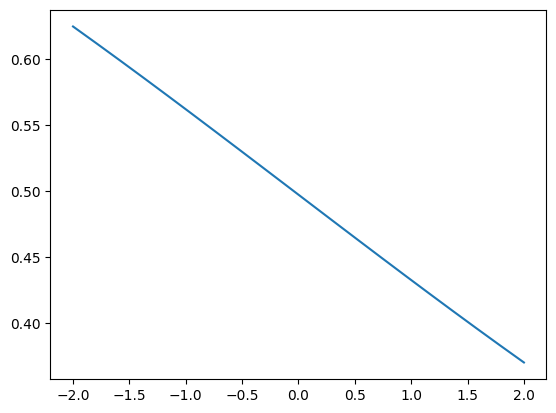

In [1835]:
x = torch.linspace(-2,2,20)
tt = torch.zeros(x.size() + torch.Size([nb_feats]))
with torch.no_grad():
    col = 1
    tt[:,col] = x 
    logits = model.logits(tt)
    p_s_given_x = np.array(torch.sigmoid(logits))[:,col]
    plt.plot(x,p_s_given_x)

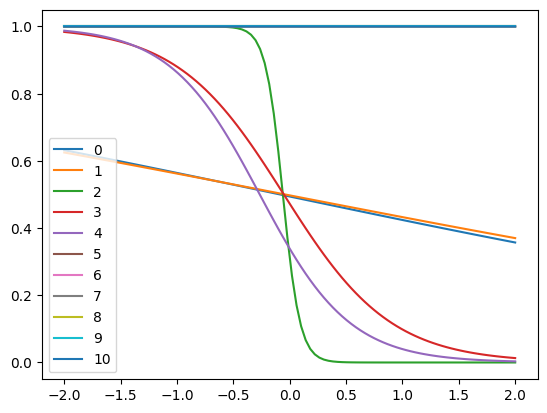

In [1836]:
x = torch.linspace(-2,2,100)

with torch.no_grad():
    logits = model.logits(x.unsqueeze(-1).expand(x.size() + torch.Size([nb_feats])))
    p_s_given_x = np.array(torch.sigmoid(logits))
    plt.plot(x,p_s_given_x,label = [str(i) for i in range(11)])
plt.legend(loc = 'lower left')

[ -0.28195596  -0.2605177  -13.037458    -2.1065748   -2.514239
  -0.8339632   -2.4290721   -0.8266785   -5.023058    -4.2070513
   3.2251062 ] [-0.08537931 -0.04031962 -0.06092377 -0.05223881 -0.26595977 14.079991
  8.621724   12.0738325   5.4177375   6.323107   -5.027139  ]


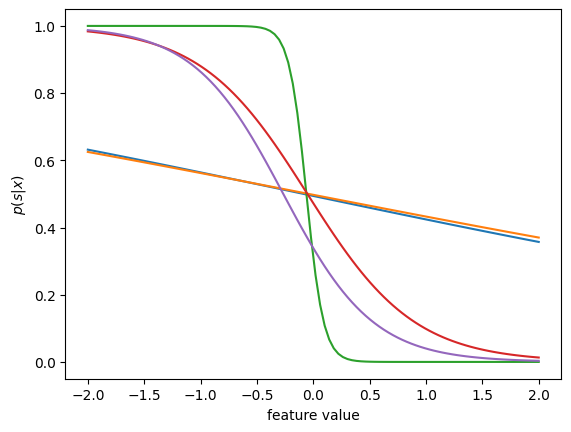

In [1837]:
_W, _b = model.logits.w.detach().numpy(), model.logits.b.detach().numpy()
print(_W, _b)
x = np.linspace(-2, 2, 100)

def sigmoid(logits):
    return 1 / (1 + np.exp(-logits))


plt.figure()

for d in range(D // 2):
    logits = _W[d] * (x - _b[d])
    psx = sigmoid(logits)
    plt.plot(x, psx)

plt.xlabel('feature value')
plt.ylabel('$p(s|x)$')
plt.show()
plt.close()

Depends on the initialization

In [1838]:
N

4898

In [1839]:
for param in model.parameters():
    print(torch.isnan(param).any().item())

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [1840]:
law_z_given_x= torch.distributions.normal.Normal(loc = torch.zeros((3,5)), scale = torch.ones((3,5)))

z_samples = law_z_given_x.sample((1,1)).squeeze()

#check size probably need to transpose
print(z_samples)
log_prob_z_given_x = law_z_given_x.log_prob(z_samples)


tensor([[-0.0640, -1.6160, -0.0969,  0.6396,  1.4429],
        [ 0.7286,  0.1933,  0.5563,  0.6797,  0.1760],
        [ 0.9306, -0.2685,  1.5226, -1.2278,  0.4318]])


In [1841]:
print( log_prob_z_given_x)

tensor([[-0.9210, -2.2246, -0.9236, -1.1235, -1.9599],
        [-1.1843, -0.9376, -1.0737, -1.1499, -0.9344],
        [-1.3519, -0.9550, -2.0782, -1.6727, -1.0122]])


In [1842]:
a = np.array([ 0.7964,  0.9837, -0.1394,  0.5177, -0.8972])
-0.7964**2 / 2 - 0.5 * np.log(2 * np.pi) 

-1.2360650132046727